In [ ]:
#Reference #1 for Doc2vec in dbow mode - https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint_3.ipynb

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

g:\ub\fall'19\venv\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
roastme_data = pd.read_csv('roastMe_dataset.csv')

In [3]:
roastme_data.shape

(25211, 4)

In [4]:
roastme_data.head(1)

,Unnamed: 0,post_id,comment,gender.value
0,0,d5vz9i,"Well thank god you’re not a language major.,Wo...",1


In [5]:
print("Size of Vocab "+ str(roastme_data['comment'].apply(lambda x: len(x.split(' '))).sum()))

Size of Vocab 27867006


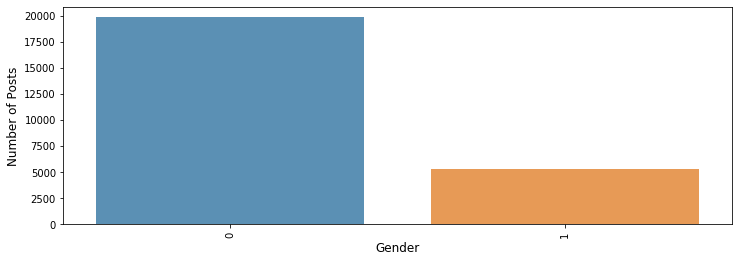

In [6]:
cnt_pro = roastme_data['gender.value'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Posts', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [7]:
#cleaning data 
# from bs4 import BeautifulSoup
def cleanText(text):
#     text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
roastme_data['comment'] = roastme_data['comment'].apply(cleanText)

In [8]:
#split train test
train, test = train_test_split(roastme_data, test_size=0.3, random_state=42)

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package stopwords to C:\Users\Niharika
[nltk_data]     Raut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [11]:
print("Train Tagged")
train_tagged = train.progress_apply(
    lambda r: TaggedDocument(words=tokenize_text(r['comment']), tags=r['gender.value']), axis=1)
print("Test Tagged")
test_tagged = test.progress_apply(
    lambda r: TaggedDocument(words=tokenize_text(r['comment']), tags=r['gender.value']), axis=1)

Train Tagged


progress-bar: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17647/17647 [06:08<00:00, 47.87it/s]


Test Tagged


progress-bar:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6522/7564 [48:35<22:47,  1.31s/it]

MemoryError: occurred at index 11776

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
